# Natural Language Processing Assignment: Spam Filter
## Import necessary libs and datasets

#### 데이터 가져오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import urllib.request

In [2]:
import numpy as np
import pandas as pd
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [3]:
#spam이 1
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data['text'] = data['v2']
data['isSpam'] = data['v1']

del data['v1'], data['v2']

print(f'Data Shape: {data.shape}')
# imbalanced data
print(data['isSpam'].value_counts())

Data Shape: (5572, 2)
0    4825
1     747
Name: isSpam, dtype: int64


### 전처리


#### 특수기호, 영어 아닌 문자, 이중 space 제거, 대문자 소문자로 전환

In [4]:
import re

pattern1 = '[^\w\s]' #특수기호 제거
pattern2 = re.compile(r'\s+') #이중 space 제거
pattern3 = re.compile('[^a-zA-Z]') #영어가 아닌 문자 공백으로 대체 

def preprocess(content)   :
    content = re.sub(pattern1, ' ', content)
    content = re.sub(pattern3, ' ', content)
    content = re.sub(pattern2, ' ', content)
    content = content.lower() #대문자 소문자로 전환
        
    return content

In [5]:
data['text_n'] = data['text'].apply(lambda x: preprocess(x))

#### 불용어 제거

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# is that a the 등 불용어 제거
from nltk.corpus import stopwords  
stopwords.words('english')[:10]  

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

def stop_word_remove(content):
    token = word_tokenize(content)
    result = []
    for w in token:
        if w not in stop_words:
            result.append(w)
    text = ' '.join(result)
    return text

In [9]:
data['text_n'] = data['text_n'].apply(lambda x: stop_word_remove(x))

#### glove pre-trained word vector 가져오기


In [10]:
import numpy as np
import gensim

In [11]:
cd /content/drive/My Drive/esc

/content/drive/My Drive/esc


In [12]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [13]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [14]:
import os
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))


400000개의 Embedding vector가 있습니다.


In [15]:
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))
#임베딩 된 벡터의 차원은 100차원 

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

#### pre-trained vector에 없는 단어 제거

In [16]:
word_list=[]
for i in data['text_n']:
    i = word_tokenize(i)
    word_list.extend(i)

In [17]:
len(word_list)

50035

In [18]:
unique_word_list=[]
for v in word_list:
    if v not in unique_word_list:
        unique_word_list.append(v)
print(len(unique_word_list))
# 7542개의 unique한 단어가 존재 

7560


In [19]:
#우리가 토큰화 한 단어 들 중 glove에서 학습된 단어 벡터가 무엇인지 알아보자
word_in_glove = []
unknown = []
for word in unique_word_list:
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        word_in_glove.append(word)
    if embedding_vector is None:
        unknown.append(word)

In [20]:
len(word_in_glove)

6253

In [21]:
def remove_word(sen):
  word_list = []
  tok = word_tokenize(sen)
  for word in tok:
    if word in word_in_glove:
        word_list.append(word)
  new_sen = " ".join(word_list)
  return new_sen

In [22]:
data['text_n'] = data['text_n'].apply(lambda x: remove_word(x))

#### X,y 데이터 처리


In [23]:
text_list = []
for i in data.text_n:
  text_list.append(str(i))

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_list)
sequences = tokenizer.texts_to_sequences(text_list)

In [25]:
#단어 인덱스
word_index = tokenizer.word_index
len(word_index)

6253

In [47]:
word_index

{'u': 1,
 'call': 2,
 'get': 3,
 'ur': 4,
 'gt': 5,
 'lt': 6,
 'ok': 7,
 'free': 8,
 'go': 9,
 'know': 10,
 'got': 11,
 'like': 12,
 'good': 13,
 'day': 14,
 'come': 15,
 'time': 16,
 'love': 17,
 'send': 18,
 'text': 19,
 'want': 20,
 'p': 21,
 'txt': 22,
 'one': 23,
 'n': 24,
 'going': 25,
 'r': 26,
 'need': 27,
 'home': 28,
 'stop': 29,
 'lor': 30,
 'k': 31,
 'today': 32,
 'sorry': 33,
 'see': 34,
 'still': 35,
 'back': 36,
 'da': 37,
 'reply': 38,
 'mobile': 39,
 'dont': 40,
 'take': 41,
 'tell': 42,
 'hi': 43,
 'new': 44,
 'later': 45,
 'pls': 46,
 'please': 47,
 'think': 48,
 'phone': 49,
 'c': 50,
 'week': 51,
 'dear': 52,
 'well': 53,
 'much': 54,
 'great': 55,
 'night': 56,
 'oh': 57,
 'claim': 58,
 'msg': 59,
 'hope': 60,
 'hey': 61,
 'na': 62,
 'b': 63,
 'wat': 64,
 'happy': 65,
 'yes': 66,
 'way': 67,
 'make': 68,
 'give': 69,
 'www': 70,
 'work': 71,
 'e': 72,
 'number': 73,
 'message': 74,
 'wan': 75,
 'prize': 76,
 'tomorrow': 77,
 'say': 78,
 'right': 79,
 'already': 80

In [26]:
#문장에 있는 최대 단어 수 
max_len=max(len(word_tokenize(l)) for l in data.text_n)
max_len

73

In [27]:
# 73차원에 맞춰서 단어수가 그 이하인 경우 제로패딩
X = pad_sequences(sequences, maxlen = max_len)

In [28]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(data.isSpam)

y = idx_encode.transform(data.isSpam)

In [29]:
print(X[0])
print(y[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    9 3446  664  594  515 1090   24   55  230  817   72 2409 1091
   11 3447   64]
0


#### 임베딩 테이블 만들기

In [53]:
embedding_dim = 100
vocab_size=len(word_index)+1 
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [54]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 

In [55]:
embedding_matrix[1]

array([-0.031087  ,  0.22155   ,  0.44494   ,  0.92176002, -0.18663   ,
        0.069117  ,  0.32929999,  0.26914999,  0.15561999,  0.31308001,
        0.61151999, -0.11215   ,  0.21906   ,  0.49480999,  0.087445  ,
        0.09159   , -0.14940999, -0.003524  ,  0.035123  ,  0.42403001,
        1.30929995,  0.38262999, -0.40788001,  0.16399001, -0.40562001,
        0.87825   ,  0.38619   ,  0.45629999,  0.90609002, -0.48334   ,
        0.30579999,  1.16970003,  0.22698   ,  0.40321001, -0.19317   ,
        0.46834999,  0.50217003,  1.2198    ,  0.11228   , -0.70321   ,
        0.16696   , -0.13545001,  0.14074001, -0.50954002,  0.10954   ,
        0.070928  , -0.43888   ,  0.57235003,  0.28055   ,  0.44428   ,
       -0.39781001,  0.28689   ,  0.40588   ,  0.25378999,  0.022166  ,
       -0.77767998, -0.28907999,  0.52274001,  1.07459998, -0.18212   ,
       -1.13880002, -0.55752999, -0.78219998, -0.31826001,  0.43900999,
        0.71710998,  0.70670998,  0.84200001,  0.014151  ,  0.37

#### train/test data 만들기


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                                   stratify=y, test_size=0.1)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5014, 73)
(5014,)
(558, 73)
(558,)


In [34]:
#random state로 데이터가 고정되어 있어서 train data를 다시 train/validation으로 쪼갬
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3509, 73)
(3509,)
(1505, 73)
(1505,)


### 모델 학습

In [36]:
label_idx={}
label_idx['ham']=0
label_idx['spam']=1
label_idx

{'ham': 0, 'spam': 1}

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate,MaxPooling1D

In [38]:
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

In [39]:
model_input = Input(shape = (max_len,))
#하나의 단어 임베딩은 훈련시키고, 나머지는 고정
z = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)
z1 = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=True)(model_input)

conv_blocks = []

#크기 3,4,5인 필터를 만듦/ 단어 임베딩을 copy했기 때문에 3개가 아니라 6개 
conv1 = Conv1D(filters = num_filters,
                         kernel_size = 3,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
conv2 = Conv1D(filters = num_filters,
                         kernel_size = 4,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
conv3 = Conv1D(filters = num_filters,
                         kernel_size = 5,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)

conv4 = Conv1D(filters = num_filters,
                         kernel_size = 3,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z1)
conv5 = Conv1D(filters = num_filters,
                         kernel_size = 4,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z1)
conv6 = Conv1D(filters = num_filters,
                         kernel_size = 5,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z1)

#maxpooling 적용
maxpooling1 = MaxPooling1D(max_len-3+1,1)(conv1)
maxpooling2 = MaxPooling1D(max_len-4+1,1)(conv2)
maxpooling3 = MaxPooling1D(max_len-5+1,1)(conv3)
maxpooling4 = MaxPooling1D(max_len-3+1,1)(conv4)
maxpooling5 = MaxPooling1D(max_len-4+1,1)(conv5)
maxpooling6 = MaxPooling1D(max_len-5+1,1)(conv6)

#6개의 maxpooling 값을 concatenate함
z = Concatenate(axis=1)([maxpooling1,maxpooling2,maxpooling3,maxpooling4,maxpooling5,maxpooling6]) 
flatten = Flatten()(z)


dropout = Dropout(drop)(flatten)
#sigmoid함수에 넣어서 함수값 출력
model_output = Dense(1, activation='sigmoid')(dropout)

model = Model(model_input, model_output)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 73, 100)      625400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 73, 100)      625400      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 71, 100)      30100       embedding[0][0]                  
_______________________________________________________________________________________

In [40]:
'''
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)
z1 = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=True)(model_input)

conv_blocks = []

conv1 = Conv1D(filters = num_filters,
                         kernel_size = 3,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
conv2 = Conv1D(filters = num_filters,
                         kernel_size = 4,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
conv3 = Conv1D(filters = num_filters,
                         kernel_size = 5,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)


maxpooling1 = MaxPooling1D(max_len-3+1,1)(conv1)
maxpooling2 = MaxPooling1D(max_len-4+1,1)(conv2)
maxpooling3 = MaxPooling1D(max_len-5+1,1)(conv3)

z = Concatenate(axis=1)([maxpooling1,maxpooling2,maxpooling3]) 
flatten = Flatten()(z)


dropout = Dropout(drop)(flatten)
model_output = Dense(1, activation='sigmoid')(dropout)

model = Model(model_input, model_output)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()
'''

'\nmodel_input = Input(shape = (max_len,))\nz = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],\n                      input_length=max_len, trainable=False)(model_input)\nz1 = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],\n                      input_length=max_len, trainable=True)(model_input)\n\nconv_blocks = []\n\nconv1 = Conv1D(filters = num_filters,\n                         kernel_size = 3,\n                         padding = "valid",\n                         activation = "relu",\n                         strides = 1)(z)\nconv2 = Conv1D(filters = num_filters,\n                         kernel_size = 4,\n                         padding = "valid",\n                         activation = "relu",\n                         strides = 1)(z)\nconv3 = Conv1D(filters = num_filters,\n                         kernel_size = 5,\n                         padding = "valid",\n                         activation = "relu",\n                         strides = 1)(

In [41]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data = (X_val, y_val))

Epoch 1/10
55/55 [==============================] - 1s 26ms/step - loss: 0.2060 - accuracy: 0.9310 - val_loss: 0.1027 - val_accuracy: 0.9694
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0643 - accuracy: 0.9789 - val_loss: 0.0738 - val_accuracy: 0.9741
Epoch 3/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0609 - val_accuracy: 0.9807
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.0636 - val_accuracy: 0.9821
Epoch 5/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0098 - accuracy: 0.9980 - val_loss: 0.0650 - val_accuracy: 0.9801
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0643 - val_accuracy: 0.9847
Epoch 7/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.0654 - val_accuracy: 0.9847
Epoch 8/10
55

### 평가

In [42]:
y_predicted = model.predict(X_test)
#y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환
y_pred=[]
for i in y_predicted:
  y_exp = (1 if i > 0.5 else 0) #1
  y_pred.append(y_exp)

In [43]:
#y_predicted = idx_encode.inverse_transform(y_predicted) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
#y_test = idx_encode.inverse_transform(y_test) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환

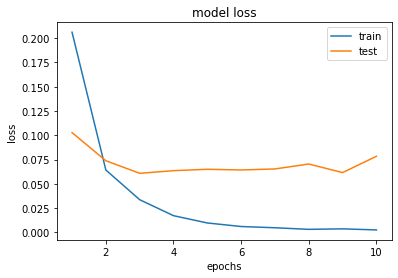

In [44]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [45]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print('accuracy: ', accuracy_score(y_test,y_pred)) #0.96
print("Recall", recall_score(y_test, y_pred)) #0.72
print("F1 score", f1_score(y_test, y_pred)) #0.83

accuracy:  0.9802867383512545
Recall 0.8666666666666667
F1 score 0.9219858156028369


In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[482,   1],
       [ 10,  65]])